In [1]:
import math
import numpy as np
import pandas as pd
from scipy import stats
import scipy.io as sio
import statsmodels
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
X = np.load('5components_es/X.npy') # SCV, Nsub x Nmode 15
Y = np.load('5components_es/Y.npy') # actual age, Nsub x 1
# TODO check brain age paper code how to process quadratic and cubic age terms
Y2 = np.load('5components_es/Y2.npy') # age terms (linear, quadratic, cubic) + sex + FD, Nsub x 5
SN = np.load('5components_es/SN.npy') # spatial normalization nuisance variable, Nsub x 3

In [3]:
def zscore(data, axis):
    data -= data.mean(axis=axis, keepdims=True)
    data /= data.std(axis=axis, keepdims=True)
    return np.nan_to_num(data, copy=False)

def correlation(matrix1, matrix2):
    d1 = matrix1.shape[-1]
    d2 = matrix2.shape[-1]

    assert d1 == d2
    assert matrix1.ndim <= 2
    assert matrix2.ndim <= 2
    
    matrix1 = zscore(matrix1.astype(float), matrix1.ndim - 1) / np.sqrt(d1)
    matrix2 = zscore(matrix2.astype(float), matrix2.ndim - 1) / np.sqrt(d2)
    
    if matrix1.ndim >= matrix2.ndim:
        return np.dot(matrix1, matrix2.T)
    else:
        return np.dot(matrix2, matrix1.T)

In [4]:
# TODO check sign
# 3, 5, 8, 16, 17
# need to flip: 3, 16, 17
for j in [0,5,10]:
    for i in [0,3,4]:
        X[:,i+j] = -1 * X[:,i+j]

In [6]:
X_residual = np.copy(X)
for i in range(15):
    X_target = X[:, i]
    X_target_norm = (X_target - np.mean(X_target)) / np.std(X_target)
    
    X_data = np.copy(X)
    X_data = np.delete(X_data, i, 1)
    # TODO double check sub and div
    X_data_norm = ( X_data - np.mean(X_data, axis=0) ) / np.std(X_data, axis=0)

    beta = np.linalg.inv( X_data_norm.T @ X_data_norm ) @ X_data_norm.T @ X_target_norm
    X_residual[:,i] = X_target_norm - X_data_norm @ beta

X_residual = ( X_residual - np.mean(X_residual, axis=0) ) / np.std(X_residual, axis=0)

In [21]:
X_modality_svd_norm_list = []
for i in range(5):
    X_modality = X[:,[i,5+i,2*5+i]]
    X_modality_norm = (X_modality - np.mean(X_modality)) / np.std(X_modality)
    C = X_modality_norm.T @ X_modality_norm # covariance matrix
    U, S, _ = np.linalg.svd(C, full_matrices=False)
    X_modality_svd = X_modality_norm @ U[:,:1]
    X_modality_svd_norm = (X_modality_svd - np.mean(X_modality_svd)) / np.std(X_modality_svd)
    X_modality_svd_norm_list.append(X_modality_svd_norm)

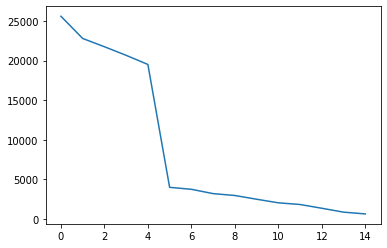

In [26]:
C = X.T @ X # covariance matrix
U, S, _ = np.linalg.svd(C, full_matrices=False)
X_svd = X @ U
plt.plot( range(len(S)), S )

In [28]:
X_modality_svd_norm_arr = np.squeeze(np.array(X_modality_svd_norm_list)).T
X_shared_residual = np.zeros( X_modality_svd_norm_arr.shape )
for i in range(5):
    X_target = X_modality_svd_norm_arr[:,i]
    X_target_norm = (X_target - np.mean(X_target)) / np.std(X_target)
    
    X_data = np.copy(X_modality_svd_norm_arr)
    X_data = np.delete(X_data, i, 1)
    X_data_norm_shared = ( X_data - np.mean(X_data, axis=0) ) / np.std(X_data, axis=0)
    X_data_norm = np.concatenate( (X_data_norm_shared, X_residual), axis=1 )

    beta = np.linalg.inv( X_data_norm.T @ X_data_norm ) @ X_data_norm.T @ X_target_norm
    X_shared_residual[:,i] = X_target_norm - X_data_norm @ beta

X_shared_residual = ( X_shared_residual - np.mean(X_shared_residual, axis=0) ) / np.std(X_shared_residual, axis=0)

In [29]:
C = X.T @ X # covariance matrix
U, S, _ = np.linalg.svd(C, full_matrices=False)
X_svd = X @ U # 

X_global_residual = np.zeros( X_svd.shape )
beta_list = []

for i in range(15):
    X_target = X_svd[:,i]
    X_target_norm = (X_target - np.mean(X_target)) / np.std(X_target)
    
    X_data = np.copy(X_svd)
    X_data = np.delete(X_data, i, 1)
    X_data_norm_global = ( X_data - np.mean(X_data, axis=0) ) / np.std(X_data, axis=0)
    X_data_norm = np.concatenate( (X_data_norm_global, X_shared_residual, X_residual), axis=1 )

    beta = np.linalg.inv( X_data_norm.T @ X_data_norm ) @ X_data_norm.T @ X_target_norm
    beta_list.append(beta)

    X_global_residual[:,i] = X_target_norm - X_data_norm @ beta

X_global_residual = ( X_global_residual - np.mean(X_global_residual, axis=0) ) / np.std(X_global_residual, axis=0)

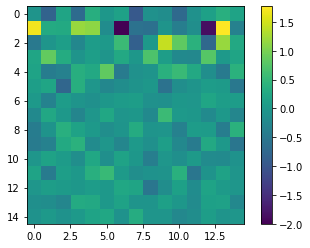

In [36]:
# corr = correlation(X_svd.T, X_global_residual.T)
cov = (X_svd.T @ X_global_residual)/(X_svd.shape[0]-1)
plt.imshow(cov)
plt.colorbar()

In [7]:
X_new = np.copy(X_residual)
Y_new = Y - np.mean(Y) # remove mean for age
Y2_demean = np.copy(Y2)

# remove mean of age terms + FD in Y, no mean removal for sex
for i in [0,1,2,4]:
    Y2_demean[:, i] = Y2[:, i] - np.mean(Y2[:, i])

# remove Y from Y sq
Y2li = np.expand_dims( Y2_demean[:, 0], axis=1 ) 
Y2sq = np.expand_dims( Y2_demean[:, 1], axis=1 ) 
Y2cu = np.expand_dims( Y2_demean[:, 2], axis=1 ) 
Y2sex = np.expand_dims( Y2_demean[:, 3], axis=1 ) 
Y2fd = np.expand_dims( Y2_demean[:, 4], axis=1 ) 

# remove Y sq from Y
Y2sq_new = Y2sq - Y2li @ ( np.linalg.pinv(Y2li) @ Y2sq )

# remove Y and Y sq from Y cu
tmp = np.concatenate( (Y2li, Y2sq), axis=1 )
Y2cu_new = Y2cu - tmp @ ( np.linalg.pinv(tmp) @ Y2cu )

# remove Y, Y sq, Y cu from sex - No!!
# Do we need to remove mean of confound? - remove it for now
Y2_new = np.copy(Y2)
Y2_new = np.delete(Y2_new, [-1], axis=1) # delete FD
Y2_new[:, 1] = np.squeeze(Y2sq_new)
Y2_new[:, 2] = np.squeeze(Y2cu_new)
Y2_new[:, 3] = np.squeeze(Y2sex)

# remove mean of age terms in Y
for i in [0,1,2]:
    Y2_new[:, i] = Y2_new[:, i] - np.mean(Y2_new[:, i])

# include age and sex interaction, 3 age terms + sex + age*sex + age^2*sex + age^3*sex + term ( remove 7 terms from fd )
Y2_new = np.concatenate((Y2_new, np.expand_dims(Y2_new[:,0]*Y2_new[:,3],axis=1), np.expand_dims(Y2_new[:,1]*Y2_new[:,3],axis=1), np.expand_dims(Y2_new[:,2]*Y2_new[:,3],axis=1)), axis=1)

# remove all terms from FD
Y2fd_new = Y2_demean[:, 4] - Y2_new @ ( np.linalg.pinv(Y2_new) @ Y2_demean[:, 4] )
Y2fd_demean = Y2fd_new - np.mean(Y2fd_new)
Y2_new = np.concatenate( (Y2_new, np.expand_dims(Y2fd_demean, axis=1)), axis=1 )

# remove all terms from SN
SN_demean = SN - np.mean(SN, axis=0)
Y2sn_new = np.copy(SN_demean)
Y2sn_demean = np.copy(SN_demean)
for i in range(3):
    Y2sn_new[:, i] = SN_demean[:, i] - Y2_new @ ( np.linalg.pinv(Y2_new) @ SN_demean[:, i] )
    Y2sn_demean[:, i] = Y2sn_new[:, i] - np.mean(Y2sn_new[:, i])

Y2_new = np.concatenate( (Y2_new, Y2sn_demean), axis=1 )

In [8]:
n_sub = X_new.shape[0]
n_mode = X_new.shape[1]

# equation 1
beta1 = np.linalg.inv( X_new.T @ X_new ) @ X_new.T @ Y_new
delta1 = X_new @ beta1 - Y_new
# print(beta1)
# print(delta1)
print('delta 1: ' + str(round(np.mean(np.abs(delta1)), 2)))

beta2 = np.linalg.inv( Y2_new.T @ Y2_new ) @ Y2_new.T @ delta1
delta2 = delta1 - Y2_new @ beta2
# print(beta2)
# print(delta2)
# all in one model
error = np.mean(np.abs(delta2))
print("delta 2: " + str(round(error, 2)))

# all in one model for each modality
# why combined delta2 is greater than single modality delta2?
for i in range(3):
    X_new_modality = X_new[:, n_mode//3*i:n_mode//3+n_mode//3*i]
    beta1_modality = np.linalg.inv( X_new_modality.T @ X_new_modality ) @ X_new_modality.T @ Y_new
    delta1_modality = X_new_modality @ beta1_modality - Y_new
    print(f"modality: {i}; delta 1: {round(np.mean(np.abs(delta1_modality)), 2)}")

    beta2_modality = np.linalg.inv( Y2_new.T @ Y2_new ) @ Y2_new.T @ delta1_modality
    delta2_modality = delta1_modality - Y2_new @ beta2_modality
    error = np.mean(np.abs(delta2_modality))
    print(f"modality: {i}; delta 2: {round(error, 2)}")

delta 1: 4.79
delta 2: 2.69
modality: 0; delta 1: 6.03
modality: 0; delta 2: 1.09
modality: 1; delta 1: 6.16
modality: 1; delta 2: 0.35
modality: 2; delta 1: 6.15
modality: 2; delta 2: 0.42


In [10]:
model = sm.OLS(Y_new, X_new).fit()
# model = sm.OLS(Y_new, X_new, hasconst=False).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.354
Model:                            OLS   Adj. R-squared (uncentered):              0.351
Method:                 Least Squares   F-statistic:                              105.6
Date:                Thu, 07 Apr 2022   Prob (F-statistic):                   1.11e-260
Time:                        15:31:32   Log-Likelihood:                         -9275.0
No. Observations:                2907   AIC:                                  1.858e+04
Df Residuals:                    2892   BIC:                                  1.867e+04
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [11]:
p_values = model.pvalues

log_p_values = np.zeros(p_values.shape) 
for i in range(log_p_values.shape[0]):
    log_p_values[i] = -math.log10(p_values[i])/100

print(p_values)
print(log_p_values)
print(-math.log10(0.05/n_mode)/100)
print(np.where(log_p_values > -math.log10(0.05/n_mode)/100))
print(np.where(p_values < 0.05/n_mode))

[2.13666619e-078 3.80033568e-021 1.46098242e-119 1.04980922e-100
 1.13786781e-018 3.12090419e-043 4.04275316e-023 1.06359914e-053
 1.20282414e-056 3.10116245e-014 9.38799373e-068 1.28113248e-024
 2.03579647e-110 8.94511965e-090 4.51566623e-014]
[0.77670263 0.20420178 1.18835355 0.9997889  0.17943908 0.4250572
 0.22393323 0.52973222 0.55919798 0.13508475 0.67027427 0.23892406
 1.09691266 0.89048414 0.13345278]
0.024771212547196626
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),)


In [12]:
beta1i = np.copy(beta1)
beta2i = np.zeros( (Y2_new.shape[1], n_mode) )
delta1i = np.zeros((n_sub, n_mode))
delta2i = np.zeros((n_sub, n_mode))
delta2i_mae = np.zeros(n_mode)

a = 1 / n_mode

for i in range(n_mode):
    # x = np.expand_dims( X_new[:,i], axis=1 )
    # beta1i[i] = np.linalg.inv( x.T @ x ) @ x.T @ Y_new
    delta1i[:, i] = X_new[:,i] * beta1i[i] - a * Y_new

    beta2i[:, i] = np.linalg.inv( Y2_new.T @ Y2_new ) @ Y2_new.T @ delta1i[:, i]
    delta2i[:, i] =  delta1i[:, i] - Y2_new @ beta2i[:, i]
    
    delta2i_mae[i] = np.mean(np.abs(delta2i[:, i]))
    print(f"Mode: {i}; Brain age error: {round(delta2i_mae[i], 2)}")

Mode: 0; Brain age error: 3.33
Mode: 1; Brain age error: 1.37
Mode: 2; Brain age error: 5.53
Mode: 3; Brain age error: 4.85
Mode: 4; Brain age error: 1.34
Mode: 5; Brain age error: 1.77
Mode: 6; Brain age error: 1.15
Mode: 7; Brain age error: 1.81
Mode: 8; Brain age error: 2.23
Mode: 9; Brain age error: 1.0
Mode: 10; Brain age error: 2.89
Mode: 11; Brain age error: 1.43
Mode: 12; Brain age error: 5.22
Mode: 13; Brain age error: 4.34
Mode: 14; Brain age error: 1.1


In [14]:
delta3i = np.copy(delta2i)
for i in range(15):
    delta2i_target = delta2i[:, i]
    delta2i_target_norm = delta2i_target - np.mean(delta2i_target)

    delta2i_data = np.copy(delta2i)
    delta2i_data = np.delete(delta2i_data, i, 1)
    delta2i_data_norm = ( delta2i_data - np.mean(delta2i_data, axis=0) ) / np.std(delta2i_data, axis=0)

    delta2i_beta = np.linalg.inv( delta2i_data_norm.T @ delta2i_data_norm ) @ delta2i_data_norm.T @ delta2i_target_norm
    delta3i[:,i] = delta2i_target_norm - delta2i_data_norm @ delta2i_beta + np.mean(delta2i_target)

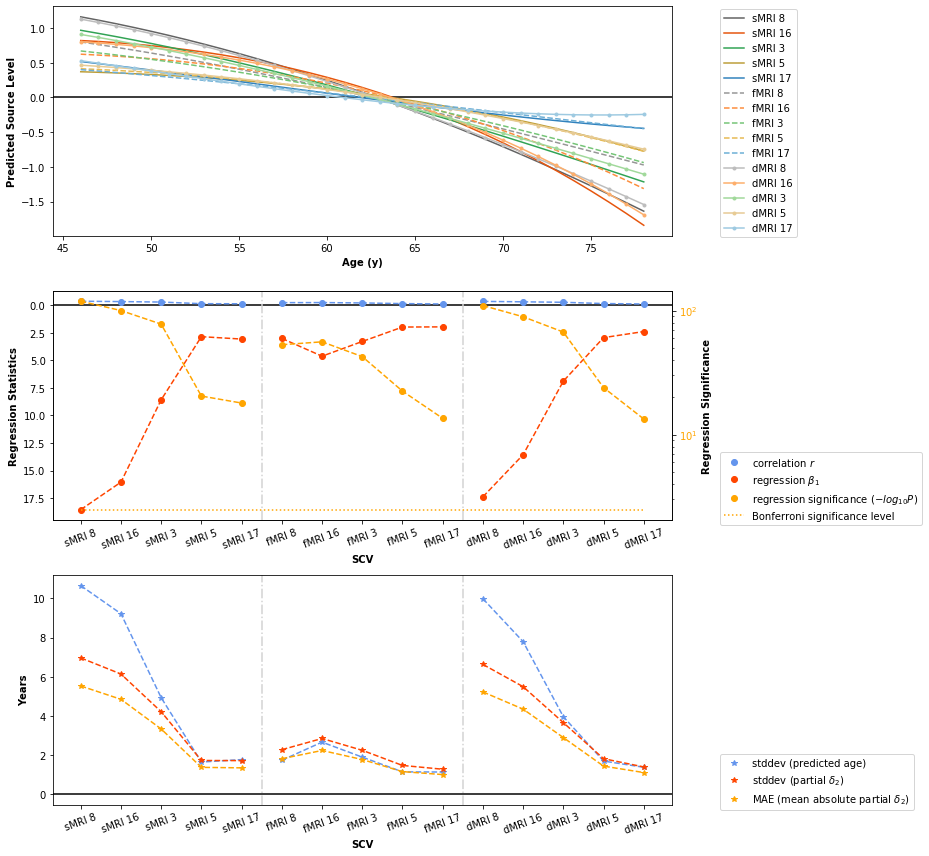

In [40]:
es = np.load(f"/Users/xinhui.li/Documents/MMIVA/UKB/postMMIVAresults/mat_files/type2_age/effect_size.npy")

# Fig S1D
# correlation
corr = np.zeros(n_mode)
for i in range(n_mode):
    corr[i] = np.corrcoef(X[:, i], Y)[0,1]
    # corr[i] = np.corrcoef(X_new[:, i], Y_new)[0,1]

corr_max = np.zeros(5)
for i in range(5):
    corr_max[i] = np.max((np.abs(corr[i]), np.abs(corr[i+5]), np.abs(corr[i+10])))
sorted_index = np.argsort(corr_max)
reversed_sorted_index = sorted_index[::-1][:sorted_index.shape[0]]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(13,12))

legend_font_size = 7
modality=['sMRI', 'fMRI', 'dMRI']
scv=[3,5,8,16,17]
xtick_label = []
for m in modality:
    for s in scv:
        xtick_label.append( m+' '+str(s) )

# Fig 1
age = np.arange( int(min(Y)), int(max(Y)) )
beta = np.linalg.inv(Y2[:, :3].T @ Y2[:, :3]) @ Y2[:, :3].T @ X

colors = []
for i in [0,1,2]:
    colors.append(sns.color_palette("tab20c")[16+i])
    colors.append(sns.color_palette("tab20c")[4+i]) 
    colors.append(sns.color_palette("tab20c")[8+i])
    colors.append(sns.color_palette("tab20b")[8+i+1])
    colors.append(sns.color_palette("tab20c")[0+i])

xtick_label_sorted = []
beta_sorted = np.copy(beta)
for i in [0, 5, 10]:
    for j in range(3):
        beta_sorted[j, i:i+5] = beta[j, i:i+5][reversed_sorted_index]
    xtick_label_sorted = xtick_label_sorted + [xtick_label[i+j] for j in reversed_sorted_index]

ax1.axhline(y=0, linestyle='-', color='black')
for i in range(n_mode):
    if i < 5:
        ax1.plot( age, beta_sorted[0,i] * age + beta_sorted[1,i] * age**2 + beta_sorted[2,i] * age**3, label=xtick_label_sorted[i], color=colors[i] )
    elif i < 10:
        ax1.plot( age, beta_sorted[0,i] * age + beta_sorted[1,i] * age**2 + beta_sorted[2,i] * age**3, '--', label=xtick_label_sorted[i], color=colors[i] )
    else:
        ax1.plot( age, beta_sorted[0,i] * age + beta_sorted[1,i] * age**2 + beta_sorted[2,i] * age**3, '.-', label=xtick_label_sorted[i], color=colors[i] )

ax1.legend(bbox_to_anchor=(1.07, 1.01))
ax1.set_xlabel('Age (y)', fontweight='bold')
ax1.set_ylabel('Predicted Source Level', fontweight='bold')

# regression significance
corr_sorted = np.copy(corr)
beta1i_sorted = np.copy(beta1i)
log_p_values = -np.log10(p_values)
log_p_values_sorted = np.copy(log_p_values)
xtick_label_sorted = []
for i in [0, 5, 10]:
    corr_sorted[i:i+5] = corr[i:i+5][reversed_sorted_index]
    beta1i_sorted[i:i+5] = beta1i[i:i+5][reversed_sorted_index]
    log_p_values_sorted[i:i+5] = log_p_values[i:i+5][reversed_sorted_index]
    xtick_label_sorted = xtick_label_sorted + [xtick_label[i+j] for j in reversed_sorted_index]

ax2.axhline(y=0, linestyle='-', color='black')
ln1 = ax2.plot(range(n_mode), corr_sorted, 'o', color='cornflowerblue', label='correlation $r$')
ax2.plot(range(5), corr_sorted[:5], '--', color='cornflowerblue')
ax2.plot(range(5, 10), corr_sorted[5:10], '--', color='cornflowerblue')
ax2.plot(range(10, 15), corr_sorted[10:], '--', color='cornflowerblue')

ln2 = ax2.plot(range(n_mode), beta1i_sorted, 'o', color='orangered', label='regression $\\beta_1$')
ax2.plot(range(5), beta1i_sorted[:5], '--', color='orangered')
ax2.plot(range(5, 10), beta1i_sorted[5:10], '--', color='orangered')
ax2.plot(range(10, 15), beta1i_sorted[10:], '--', color='orangered')
ax2.axvline(x=n_mode/3-0.5, linestyle='-.', color='lightgray')
ax2.axvline(x=2*n_mode/3-0.5, linestyle='-.', color='lightgray')
ax2.set_xlabel('SCV', fontweight='bold')
ax2.set_ylabel('Regression Statistics', fontweight='bold')
ax2.set_xticks(range(n_mode))
ax2.set_xticklabels(xtick_label_sorted, rotation=20)
ax2.invert_yaxis()

# ln5 = ax2.plot(range(n_mode), es, 'o', color='lightgreen', label='effect size $(\epsilon^2)$')
# ax2.plot(range(n_mode), es, '--', color='lightgreen')

ax22 = ax2.twinx()
ln3 = ax22.plot(range(n_mode), log_p_values_sorted, 'o', color='orange', label='regression significance $(-log_{10}P)$')
# ax22.plot(range(n_mode), -np.log10(p_values), '--', color='orange')
ax22.plot(range(5), log_p_values_sorted[:5], '--', color='orange')
ax22.plot(range(5, 10), log_p_values_sorted[5:10], '--', color='orange')
ax22.plot(range(10, 15), log_p_values_sorted[10:], '--', color='orange')
ln4 = ax22.plot(range(n_mode), np.repeat(-np.log10(0.05/n_mode), n_mode), linestyle=':', color='orange', label='Bonferroni significance level')
ax22.set_yscale('log')
ax22.set_ylabel('Regression Significance', fontweight='bold')
ax22.tick_params(axis='y', labelcolor='orange')

ln = ln1+ln2+ln3+ln4#+ln5
lab = [l.get_label() for l in ln]
ax2.legend(ln, lab, bbox_to_anchor=(1.07, 0.32))

# Fig S1B
delta1i_std = np.std(delta1i, axis=0)
delta2i_std = np.std(delta2i, axis=0)
predicted_age_std = np.zeros(n_mode)
for i in range(n_mode):
    predicted_age = X_new * beta1i[i]
    predicted_age_std[i] = np.std(predicted_age)

delta2i_sorted = np.copy(delta2i)
delta3i_sorted = np.copy(delta3i)
delta1i_std_sorted = np.copy(delta1i_std)
delta2i_std_sorted = np.copy(delta2i_std)
predicted_age_std_sorted = np.copy(predicted_age_std)
delta2i_mae_sorted = np.copy(delta2i_mae)
for i in [0, 5, 10]:
    delta1i_std_sorted[i:i+5] = delta1i_std[i:i+5][reversed_sorted_index]
    delta2i_std_sorted[i:i+5] = delta2i_std[i:i+5][reversed_sorted_index]
    predicted_age_std_sorted[i:i+5] = predicted_age_std[i:i+5][reversed_sorted_index]
    delta2i_mae_sorted[i:i+5] = delta2i_mae[i:i+5][reversed_sorted_index]
    delta2i_sorted[:,i:i+5] = delta2i[:,i:i+5][:,reversed_sorted_index]
    delta3i_sorted[:,i:i+5] = delta3i[:,i:i+5][:,reversed_sorted_index]

ax3.axhline(y=0, linestyle='-', color='black')

ax3.plot(range(n_mode), predicted_age_std_sorted, '*', color='cornflowerblue', label='stddev (predicted age)')
ax3.plot(range(5), predicted_age_std_sorted[:5], '--', color='cornflowerblue')
ax3.plot(range(5, 10), predicted_age_std_sorted[5:10], '--', color='cornflowerblue')
ax3.plot(range(10, 15), predicted_age_std_sorted[10:], '--', color='cornflowerblue')

ax3.plot(range(n_mode), delta2i_std_sorted, '*', color='orangered', label='stddev (partial $\delta_2$)')
ax3.plot(range(5), delta2i_std_sorted[:5], '--', color='orangered')
ax3.plot(range(5, 10), delta2i_std_sorted[5:10], '--', color='orangered')
ax3.plot(range(10, 15), delta2i_std_sorted[10:], '--', color='orangered')

ax3.plot(range(n_mode), delta2i_mae_sorted, '*', color='orange', label='MAE (mean absolute partial $\delta_2$)')
ax3.plot(range(5), delta2i_mae_sorted[:5], '--', color='orange')
ax3.plot(range(5, 10), delta2i_mae_sorted[5:10], '--', color='orange')
ax3.plot(range(10, 15), delta2i_mae_sorted[10:], '--', color='orange')

ax3.axvline(x=n_mode/3-0.5, linestyle='-.', color='lightgray')
ax3.axvline(x=2*n_mode/3-0.5, linestyle='-.', color='lightgray')
ax3.legend(bbox_to_anchor=(1.07, 0.24))
ax3.set_xlabel('SCV', fontweight='bold')
ax3.set_ylabel('Years', fontweight='bold')
ax3.set_xticks(range(n_mode))
ax3.set_xticklabels(xtick_label_sorted, rotation=20)

plt.tight_layout()
plt.savefig('fig2_age_partial_delta.pdf', dpi=300)

In [29]:
mat_path = "/Users/xinhui.li/Documents/MMIVA/UKB/postMMIVAresults/mat_files/UKB_MMIVA_C30_preregSite_SMRI_MancovanOuts_wX_FINAL.mat"
mat_file = sio.loadmat(mat_path)

predictor_array = mat_file['DEMO0s_ful'][0][0][1]
predictor_name = mat_file['DEMO0s_ful'][0][0][2][0]
sex_ind = np.where(predictor_name=='sex_f31_0_0')[0][0]
age_ind = np.where(predictor_name=='age_when_attended_assessment_centre_f21003_2_0')[0][0]
sn_ind = np.where(predictor_name=='rSpatNorm')[0][0]
sex = predictor_array[:, sex_ind]

In [30]:
ukb_2907sub_62var_path = "/Users/xinhui.li/Documents/MMIVA/UKB/postMMIVAresults/mat_files/ukb_2907sub_62var.mat"
ukb_2907sub_62var = sio.loadmat(ukb_2907sub_62var_path)['ukbDEMO_2907_lt5nan']

ukb_64var_path = "/Users/xinhui.li/Documents/MMIVA/UKB/postMMIVAresults/mat_files/ukb_64var.mat"
ukb_64var = np.squeeze(sio.loadmat(ukb_64var_path)['headUKB'])

In [31]:
id_ind = np.where(ukb_64var=='eid')[0][0]
gen_sex_ind = np.where(ukb_64var=='genetic_sex_f22001_0_0')[0][0]

ukb_62var = np.delete(ukb_64var, [id_ind, gen_sex_ind], 0)

In [32]:
sex_ind = np.where(ukb_62var=='sex_f31_0_0')[0][0]
age_ind = np.where(ukb_62var=='age_when_attended_assessment_centre_f21003_2_0')[0][0]

ukb_60var = np.delete(ukb_62var, [sex_ind, age_ind], 0)
ukb_2907sub_60var = np.delete(ukb_2907sub_62var, [sex_ind, age_ind], 1)

In [41]:
sex = ukb_2907sub_62var[:,sex_ind]
corr_delta3i_predictor_m = correlation(delta3i_sorted[sex==0,:].T, ukb_2907sub_60var[sex==0,:].T)
corr_delta3i_predictor_f = correlation(delta3i_sorted[sex==1,:].T, ukb_2907sub_60var[sex==1,:].T)
corr_delta3i_predictor = correlation(delta3i_sorted.T, ukb_2907sub_60var.T)

In [42]:
np.max(corr_delta3i_predictor_m), np.max(corr_delta3i_predictor_f), np.max(corr_delta3i_predictor)

(0.14509312828388435, 0.13229870762914378, 0.13597984222767814)

In [43]:
np.min(corr_delta3i_predictor_m), np.min(corr_delta3i_predictor_f), np.min(corr_delta3i_predictor)

(-0.10996337610086188, -0.07246298485860446, -0.14178363955685344)

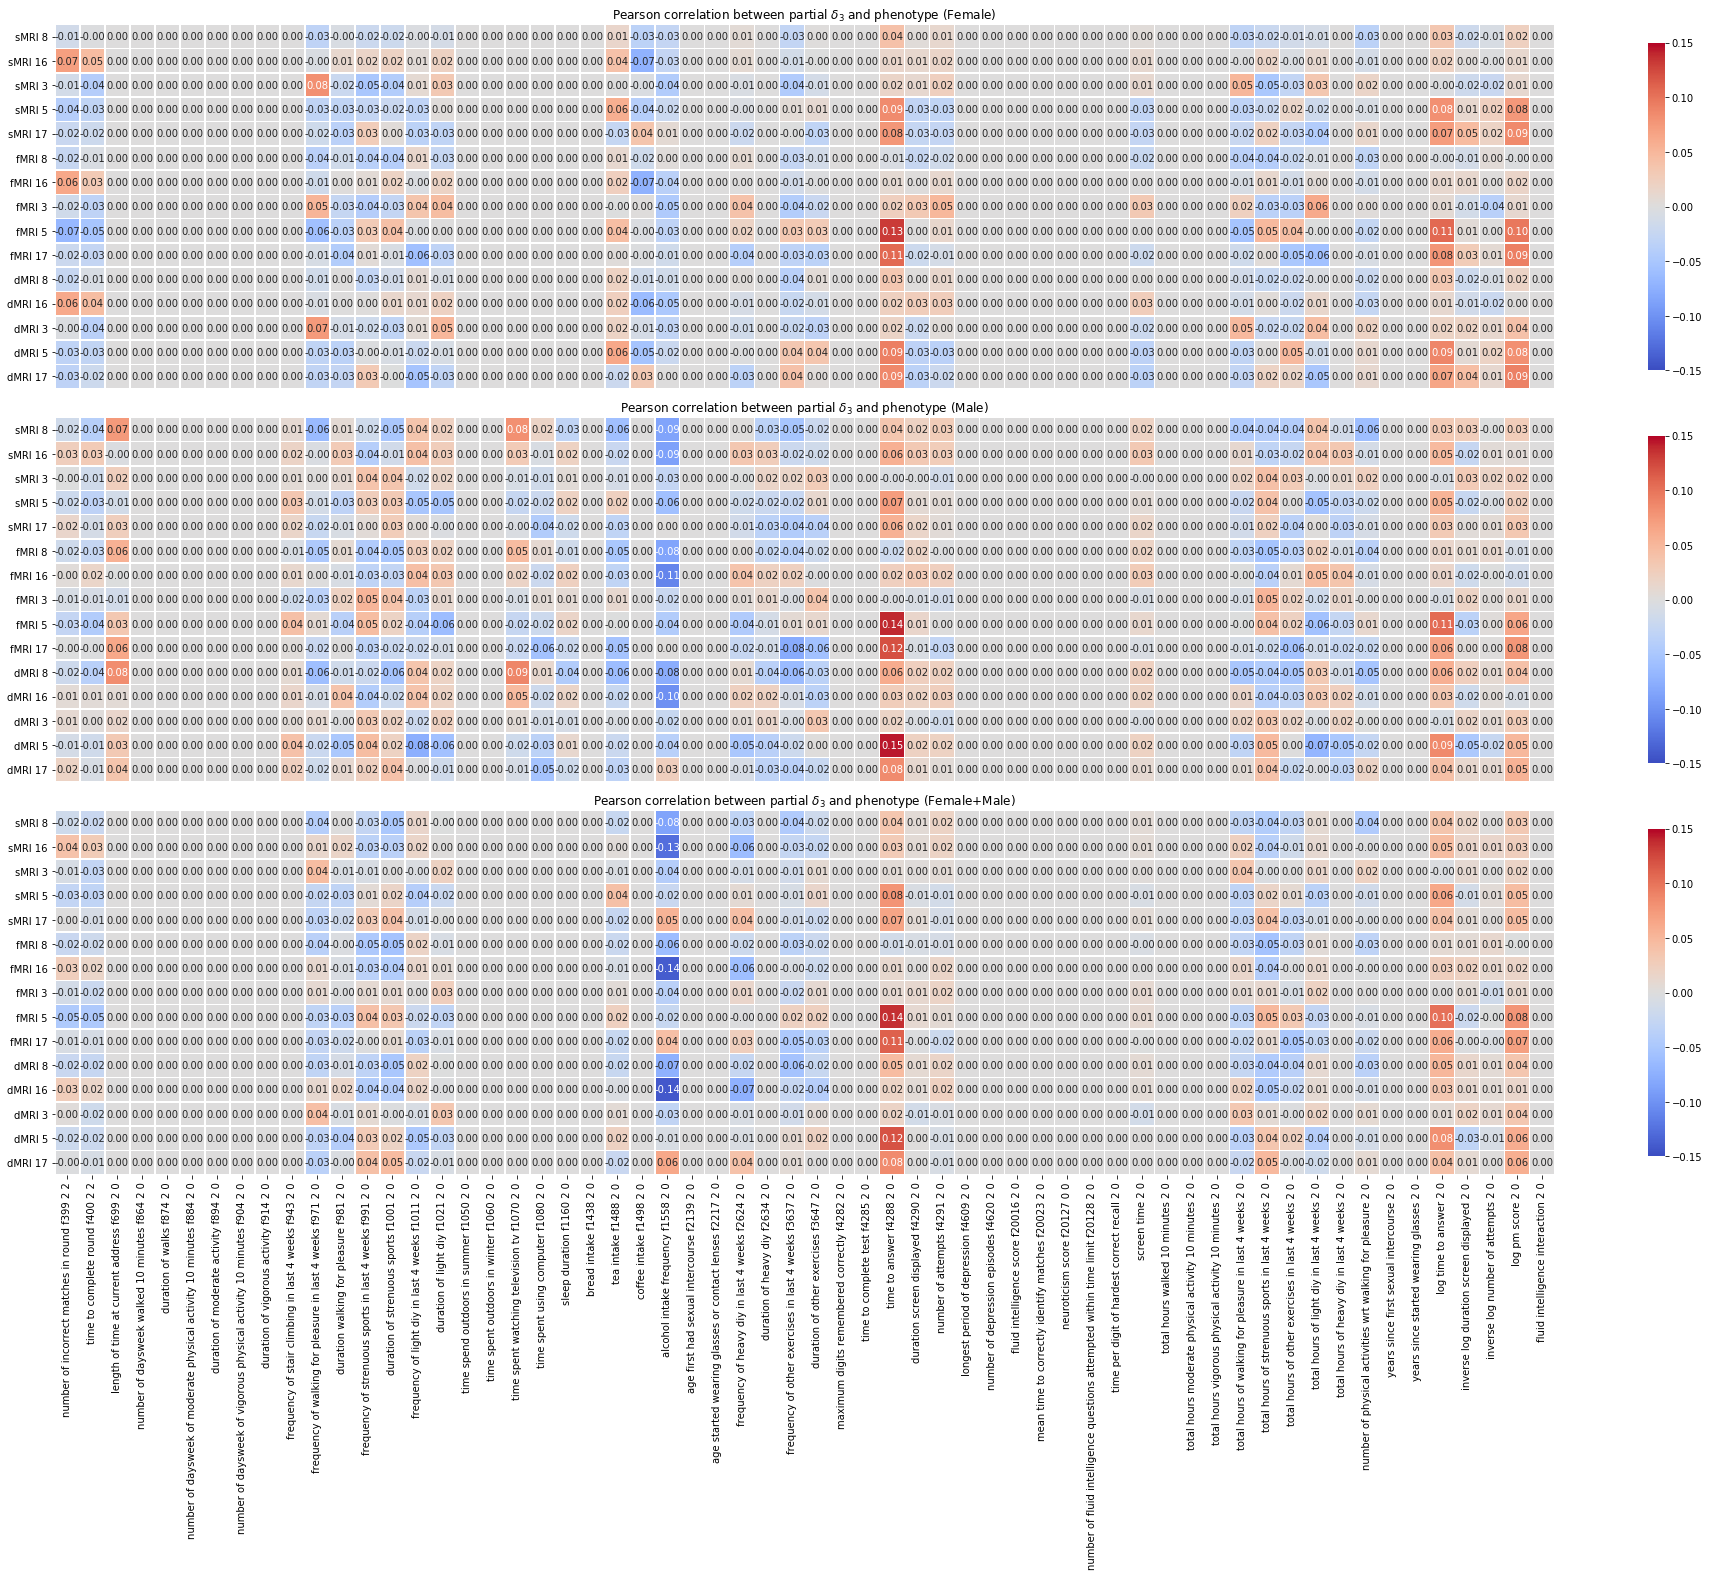

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(27,22))

xticks = np.arange(0.5, 60.5, 1)
xticklabels = []
for i in range(60):
    pn = ukb_60var[i][0]
    xticklabels.append(pn.replace('_', ' '))

yticks = np.arange(0.5, 15.5, 1)
g1 = sns.heatmap(corr_delta3i_predictor_f, annot=True, linewidths=.5, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .9}, vmin=-0.15, vmax=0.15, xticklabels=False, yticklabels=xtick_label_sorted, ax=ax1)
g1.set_title("Pearson correlation between partial $\delta_{3}$ and phenotype (Female)")
g1.set_yticks(yticks)
g1.set_yticklabels(g1.get_yticklabels(), rotation=0)

g2 = sns.heatmap(corr_delta3i_predictor_m, annot=True, linewidths=.5, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .9}, vmin=-0.15, vmax=0.15, xticklabels=False, yticklabels=xtick_label_sorted, ax=ax2)
g2.set_title("Pearson correlation between partial $\delta_{3}$ and phenotype (Male)")
g2.set_yticks(yticks)
g2.set_yticklabels(g2.get_yticklabels(), rotation=0)

g3 = sns.heatmap(corr_delta3i_predictor, annot=True, linewidths=.5, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .9}, vmin=-0.15, vmax=0.15, xticklabels=xticklabels, yticklabels=xtick_label_sorted, ax=ax3)
g3.set_title("Pearson correlation between partial $\delta_{3}$ and phenotype (Female+Male)")
g3.set_xticks(xticks)
g3.set_yticks(yticks)
g3.set_yticklabels(g3.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig("partial_delta3_60var_corr.pdf", dpi=200)

In [50]:
def mask(arr):
    ind = ~np.isnan(arr)
    arr_ = arr[ind]
    return arr_, ind

num_var = 60
num_scv = 15
r = np.zeros( (3, num_scv, num_var) )
p = np.zeros( (3, num_scv, num_var) )

# TODO create a mask
# ukb_2907sub_60var = np.nan_to_num(ukb_2907sub_60var)
for i in range(num_scv):
    for j in range(num_var):
        var_male, ind_male = mask(ukb_2907sub_60var[sex==0,j])
        var_female, ind_female = mask(ukb_2907sub_60var[sex==1,j])
        var_all, ind_all = mask(ukb_2907sub_60var[:,j])
        delta_3i_male = delta3i_sorted[sex==0,i][ind_male]
        delta_3i_female = delta3i_sorted[sex==1,i][ind_female]
        delta_3i_all = delta3i_sorted[:,i][ind_all]
        try:
            r[0,i,j], p[0,i,j] = stats.pearsonr(delta_3i_male, var_male)
            r[1,i,j], p[1,i,j] = stats.pearsonr(delta_3i_female, var_female)
            r[2,i,j], p[2,i,j] = stats.pearsonr(delta_3i_all, var_all)
        except ValueError:
            print(i, j)
        j = j + 1

# fMRI 5 and dMRI 5 are correlated
# Benjamini-Hotchberg: work for both independent and positively correlated, p-values on spatial maps
# rejected T: significant
# FDR: balance type 1 and type 2 (false negative) error, false discovery rate
# Bonferrorni: the strictest test, optimize for minimizing false positives (type 1)
p_corrected = np.zeros( (3, num_scv, num_var) )
rej = np.zeros( (3, num_scv, num_var) )
for i in range(3):
    rejected, pval_corrected = statsmodels.stats.multitest.fdrcorrection(p[i,:,:].flatten(), alpha=0.05, method='poscorr', is_sorted=False)
    p_corrected[i,:,:] = pval_corrected.reshape( (num_scv, num_var) )
    rej[i,:,:] = rejected.reshape( (num_scv, num_var) )

In [ ]:
# p-value of beta variable in linear model = p = sqrt(R^2)

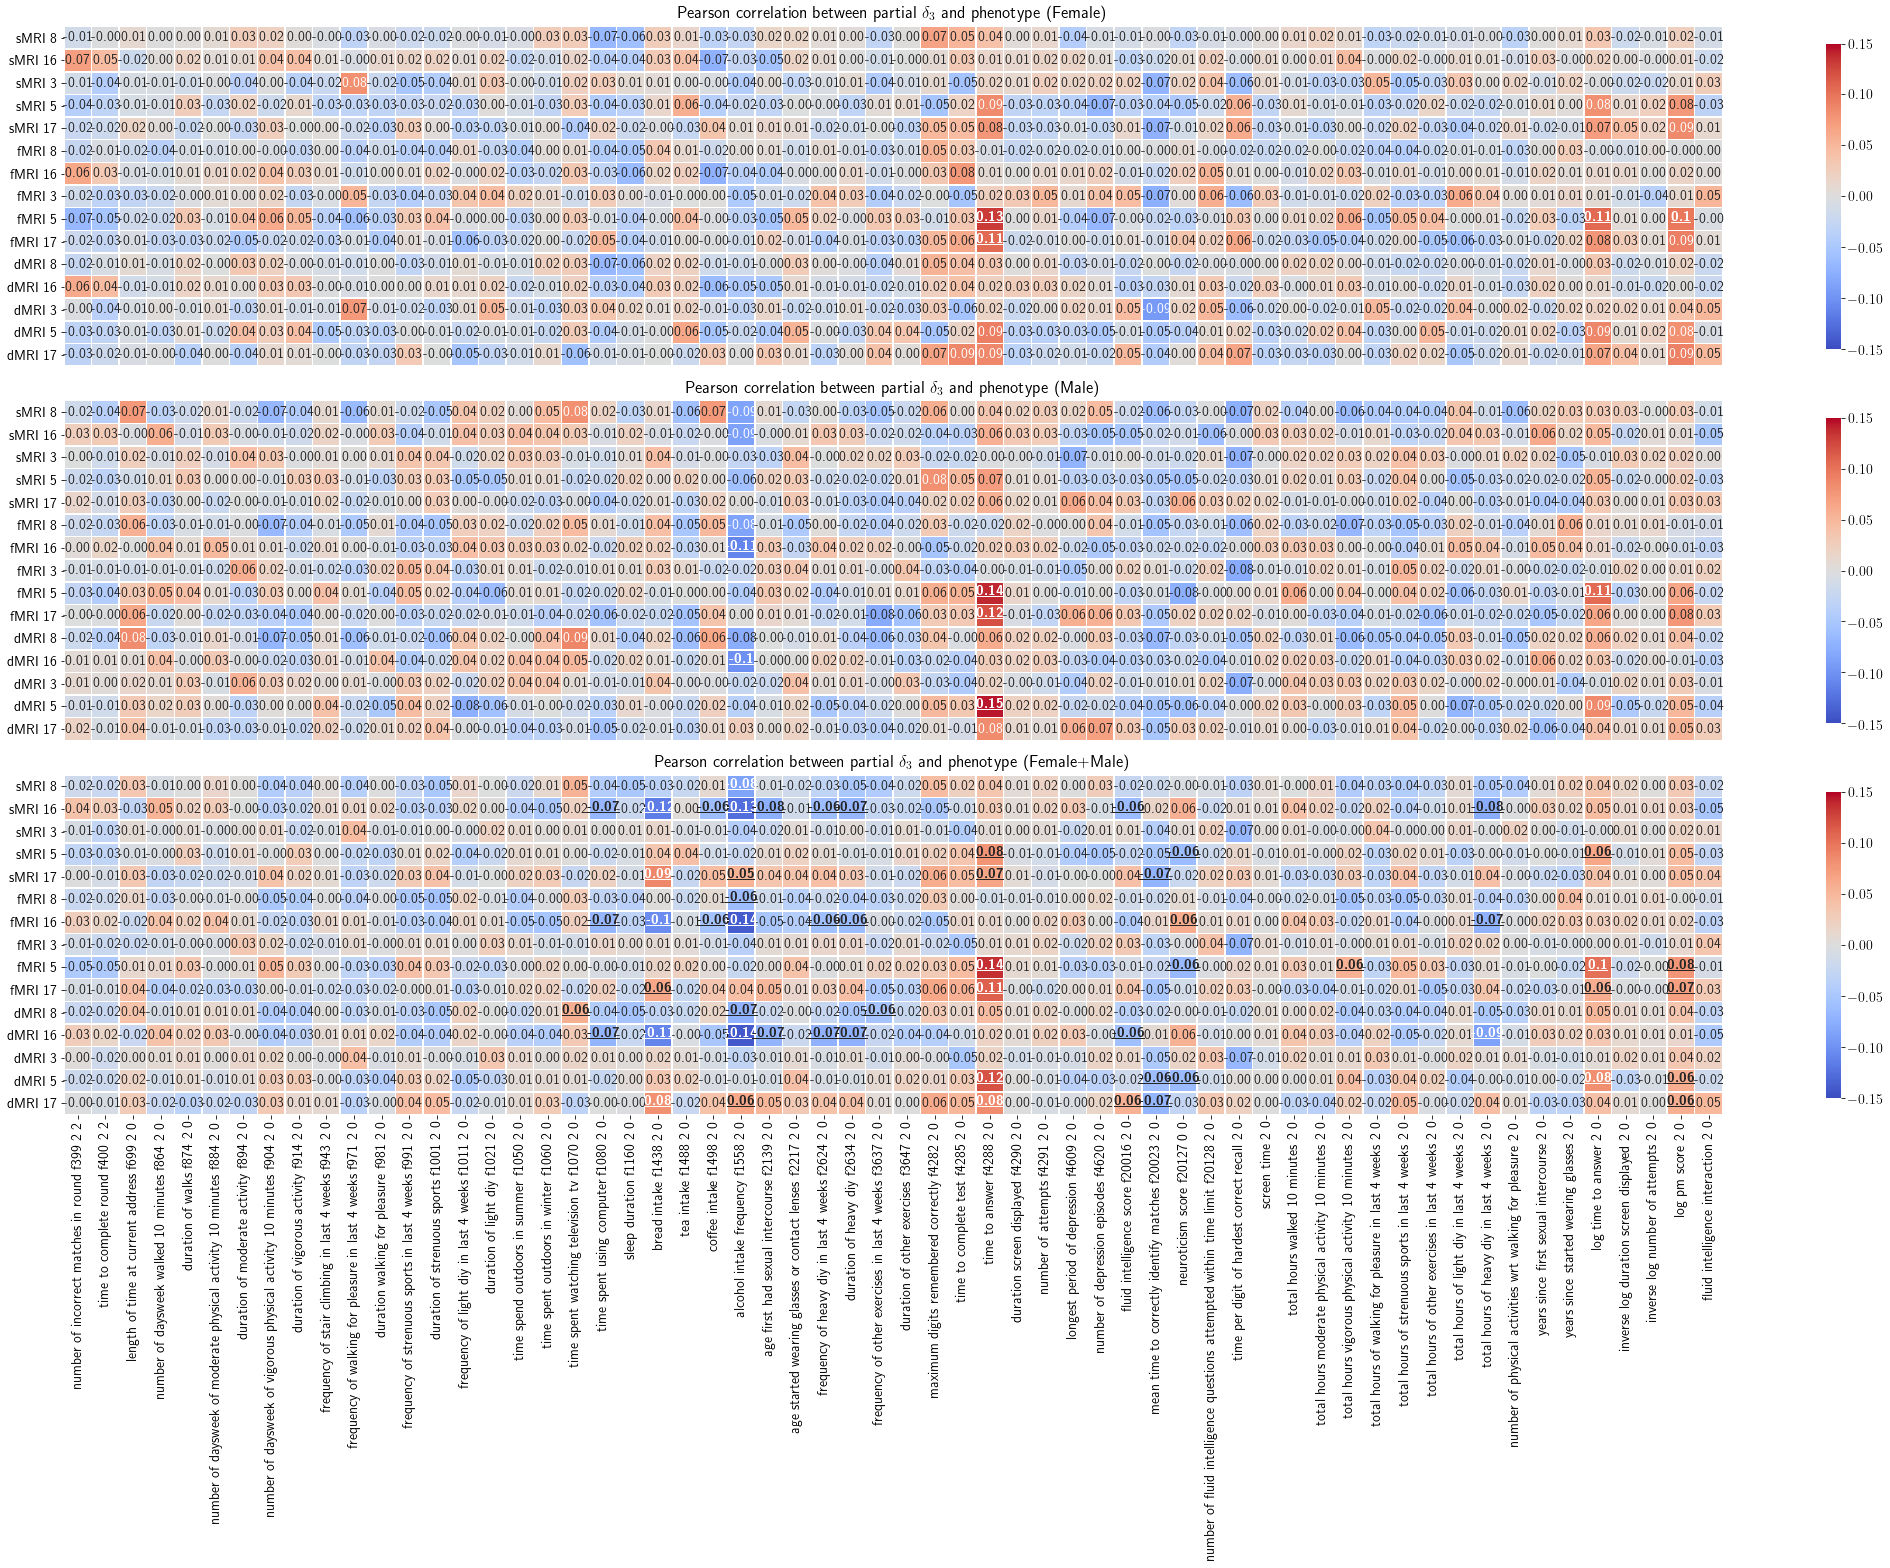

In [52]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30,22))

xticks = np.arange(0.5, 60.5, 1)
xticklabels = []
for i in range(num_var):
    pn = ukb_60var[i][0]
    xticklabels.append(pn.replace('_', ' '))

# Activating tex in all labels globally
plt.rc('text', usetex=True)
# Adjust font specs as desired (here: closest similarity to seaborn standard)
plt.rc('font', **{'size': 14.0})

yticks = np.arange(0.5, num_scv+0.5, 1)
g1 = sns.heatmap(r[1,:,:], mask=rej[1,:,:], annot=True, linewidths=.5, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .9}, vmin=-0.15, vmax=0.15, xticklabels=False, yticklabels=xtick_label_sorted, ax=ax1)
g1.set_title("Pearson correlation between partial $\delta_{3}$ and phenotype (Female)")
g1.set_yticks(yticks)
g1.set_yticklabels(g1.get_yticklabels(), rotation=90)
sns.heatmap(r[1,:,:], mask=rej[1,:,:]==False, 
            # Use annot key with np.array as value containing strings of data + latex 
            # prefixes/suffices making the bold/italic/underline formatting
            # annot=np.array([r'\emph{\underline{' + str(round(data,2)) + '}}'
            #             for data in corr_delta2i_predictor_f.ravel()]).reshape(
            # np.shape(corr_delta2i_predictor_f)),
            annot=np.array([r'\textbf{\underline{' + str(round(data,2)) + '}}'
                        for data in r[1,:,:].ravel()]).reshape(
            np.shape(r[1,:,:])),
            linewidths=.5, fmt='', cmap="coolwarm", cbar=False, cbar_kws={"shrink": .9}, vmin=-0.15, vmax=0.15, xticklabels=False, yticklabels=xtick_label_sorted, ax=ax1)

g2 = sns.heatmap(r[0,:,:], mask=rej[0,:,:], annot=True, linewidths=.5, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .9}, vmin=-0.15, vmax=0.15, xticklabels=False, yticklabels=xtick_label_sorted, ax=ax2)
g2.set_title("Pearson correlation between partial $\delta_{3}$ and phenotype (Male)")
g2.set_yticks(yticks)
g2.set_yticklabels(g2.get_yticklabels(), rotation=90)
# g2.set_xlabel("Phenotype", fontdict={'weight': 'bold'})
# g2.set_ylabel("SCV", fontdict={'weight': 'bold'})
sns.heatmap(r[0,:,:], mask=rej[0,:,:]==False, 
            # Use annot key with np.array as value containing strings of data + latex 
            # prefixes/suffices making the bold/italic/underline formatting
            # annot=np.array([r'\emph{\underline{' + str(round(data,2)) + '}}'
            #             for data in corr_delta2i_predictor_m.ravel()]).reshape(
            # np.shape(corr_delta2i_predictor_m)),
            annot=np.array([r'\textbf{\underline{' + str(round(data,2)) + '}}'
                        for data in r[0,:,:].ravel()]).reshape(
            np.shape(r[0,:,:])),
            linewidths=.5, fmt='', cmap="coolwarm", cbar=False, cbar_kws={"shrink": .9}, vmin=-0.15, vmax=0.15, xticklabels=False, yticklabels=xtick_label_sorted, ax=ax2)

g3 = sns.heatmap(r[2,:,:], mask=rej[2,:,:], annot=True, linewidths=.5, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .9}, vmin=-0.15, vmax=0.15, xticklabels=xticklabels, yticklabels=xtick_label_sorted, ax=ax3)
g3.set_title("Pearson correlation between partial $\delta_{3}$ and phenotype (Female+Male)")
g3.set_xticks(xticks)
g3.set_yticks(yticks)
g3.set_yticklabels(g3.get_yticklabels(), rotation=90)
sns.heatmap(r[2,:,:], mask=rej[2,:,:]==False, 
            # Use annot key with np.array as value containing strings of data + latex 
            # prefixes/suffices making the bold/italic/underline formatting
            # annot=np.array([r'\emph{\underline{' + str(round(data,2)) + '}}'
            #             for data in corr_delta2i_predictor.ravel()]).reshape(
            # np.shape(corr_delta2i_predictor)),
            annot=np.array([r'\textbf{\underline{' + str(round(data,2)) + '}}'
                        for data in r[2,:,:].ravel()]).reshape(
            np.shape(r[2,:,:])),
            linewidths=.5, fmt='', cmap="coolwarm", cbar=False, cbar_kws={"shrink": .9}, vmin=-0.15, vmax=0.15, xticklabels=xticklabels, yticklabels=xtick_label_sorted, ax=ax3)

plt.tight_layout()
plt.savefig("partial_delta3_60var_corr_underscore.pdf", dpi=200)

In [53]:
log_p_corrected = np.zeros((3, num_scv, num_var))

for i in range(3):
    for j in range(num_scv):
        for k in range(num_var):
            log_p_corrected[i,j,k] = -math.log10(p_corrected[i,j,k])

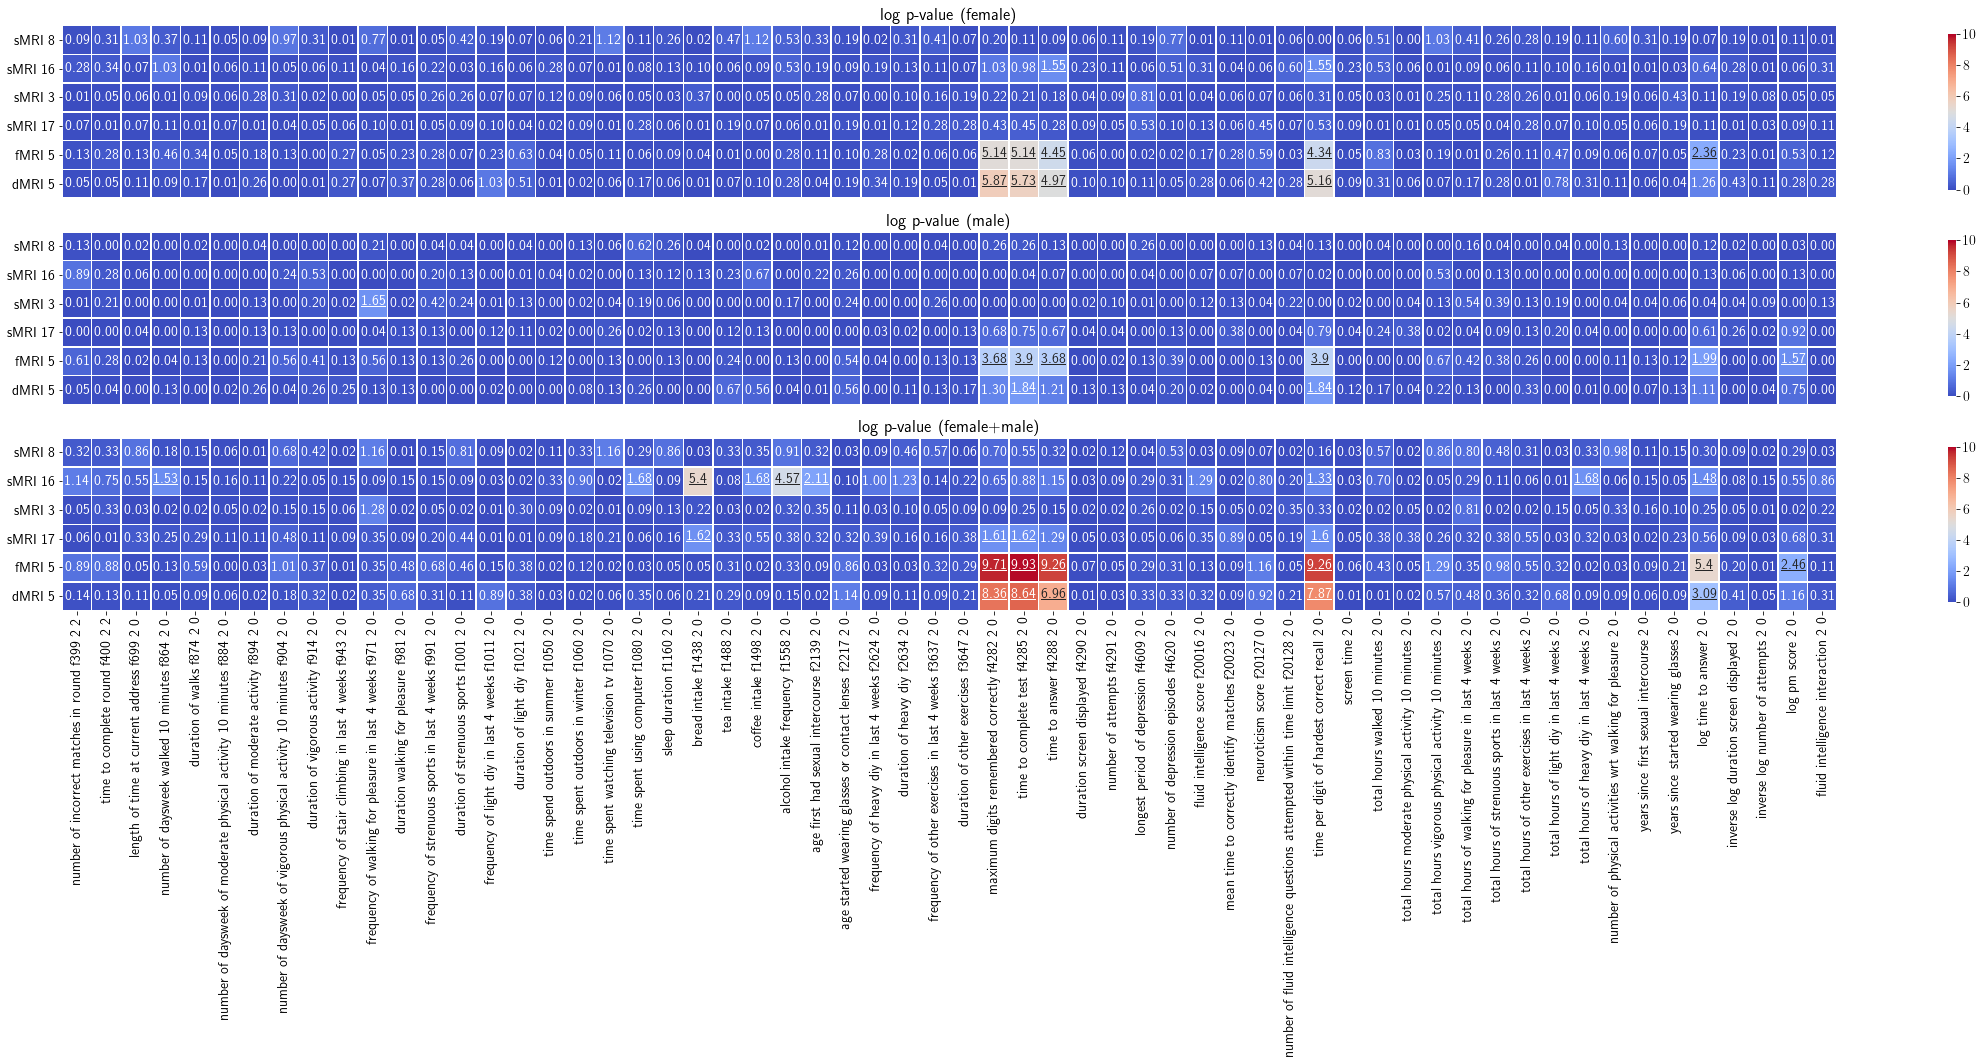

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(32,15))

xticks = np.arange(0.5, 60.5, 1)
xticklabels = []
for i in range(60):
    pn = ukb_60var[i][0]
    xticklabels.append(pn.replace('_', ' '))

yticks = np.arange(0.5, 6.5, 1)
g1 = sns.heatmap(log_p_corrected[0,:,:], mask=rej[0,:,:], annot=True, linewidths=.5, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .9}, vmin=0, vmax=10, xticklabels=False, yticklabels=xtick_label_sorted_selected, ax=ax1)
g1.set_title("log p-value (female)")
g1.set_yticks(yticks)
g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
sns.heatmap(log_p_corrected[0,:,:], mask=rej[0,:,:]==False, 
            # Use annot key with np.array as value containing strings of data + latex 
            # prefixes/suffices making the bold/italic/underline formatting
            annot=np.array([r'\underline{' + str(round(data,2)) + '}'
                        for data in log_p_corrected[0,:,:].ravel()]).reshape(
            np.shape(log_p_corrected[0,:,:])),
            linewidths=.5, fmt='', cmap="coolwarm", cbar=False, cbar_kws={"shrink": .9}, vmin=0, vmax=10, xticklabels=False, yticklabels=xtick_label_sorted_selected, ax=ax1)

g2 = sns.heatmap(log_p_corrected[1,:,:], mask=rej[1,:,:], annot=True, linewidths=.5, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .9}, vmin=0, vmax=10, xticklabels=False, yticklabels=xtick_label_sorted_selected, ax=ax2)
g2.set_title("log p-value (male)")
g2.set_yticks(yticks)
g2.set_yticklabels(g2.get_yticklabels(), rotation=0)
# g2.set_xlabel("Phenotype", fontdict={'weight': 'bold'})
# g2.set_ylabel("SCV", fontdict={'weight': 'bold'})
sns.heatmap(log_p_corrected[1,:,:], mask=rej[1,:,:]==False, 
            # Use annot key with np.array as value containing strings of data + latex 
            # prefixes/suffices making the bold/italic/underline formatting
            annot=np.array([r'\underline{' + str(round(data,2)) + '}'
                        for data in log_p_corrected[1,:,:].ravel()]).reshape(
            np.shape(log_p_corrected[1,:,:])),
            linewidths=.5, fmt='', cmap="coolwarm", cbar=False, cbar_kws={"shrink": .9}, vmin=0, vmax=10, xticklabels=False, yticklabels=xtick_label_sorted_selected, ax=ax2)

g3 = sns.heatmap(log_p_corrected[2,:,:], mask=rej[2,:,:], annot=True, linewidths=.5, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .9}, vmin=0, vmax=10, xticklabels=xticklabels, yticklabels=xtick_label_sorted_selected, ax=ax3)
g3.set_title("log p-value (female+male)")
g3.set_xticks(xticks)
g3.set_yticks(yticks)
g3.set_yticklabels(g3.get_yticklabels(), rotation=0)
sns.heatmap(log_p_corrected[2,:,:], mask=rej[2,:,:]==False, 
            # Use annot key with np.array as value containing strings of data + latex 
            # prefixes/suffices making the bold/italic/underline formatting
            annot=np.array([r'\underline{' + str(round(data,2)) + '}'
                        for data in log_p_corrected[2,:,:].ravel()]).reshape(
            np.shape(log_p_corrected[2,:,:])),
            linewidths=.5, fmt='', cmap="coolwarm", cbar=False, cbar_kws={"shrink": .9}, vmin=0, vmax=10, xticklabels=xticklabels, yticklabels=xtick_label_sorted_selected, ax=ax3)

plt.tight_layout()
# plt.savefig("delta2i_60var_corr_log_pval.pdf", dpi=200)

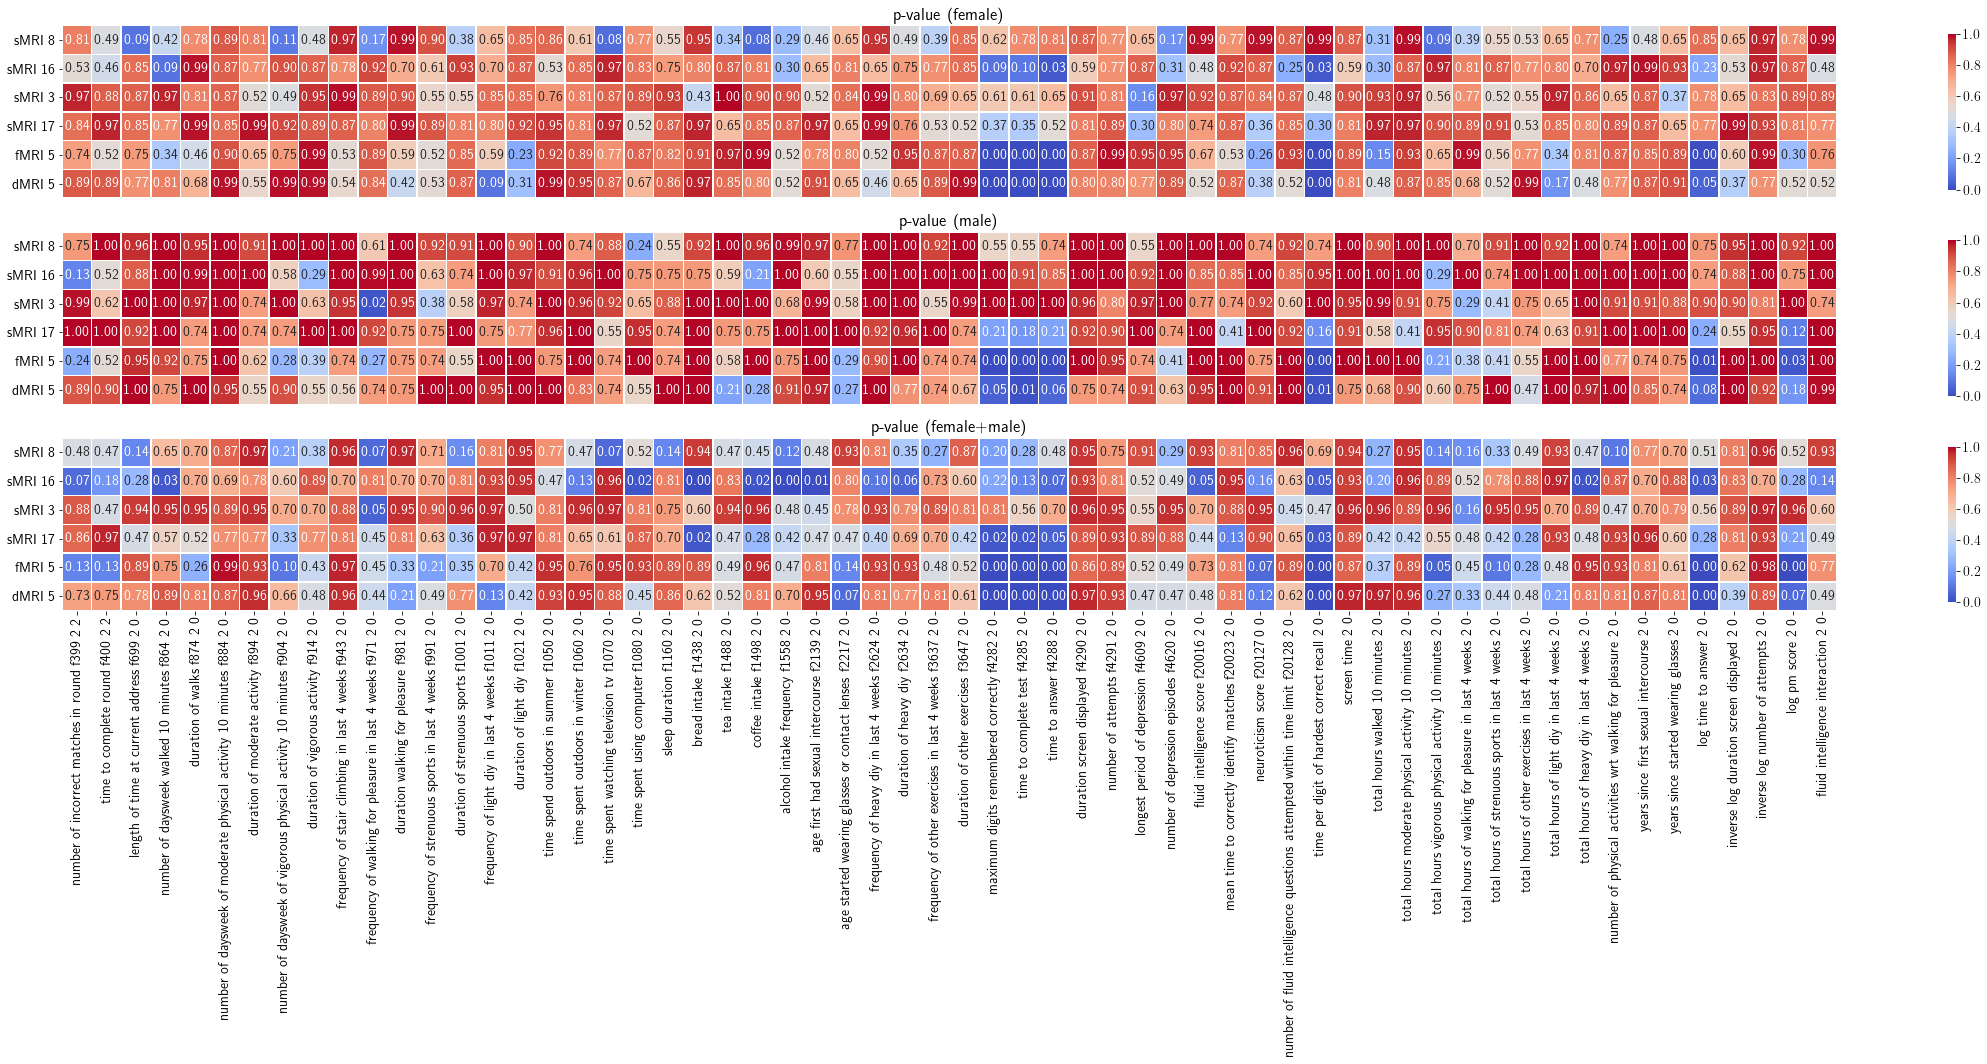

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(32,15))

xticks = np.arange(0.5, 60.5, 1)
xticklabels = []
for i in range(60):
    pn = ukb_60var[i][0]
    xticklabels.append(pn.replace('_', ' '))

yticks = np.arange(0.5, 6.5, 1)
g1 = sns.heatmap(p_corrected[0,:,:], annot=True, linewidths=.5, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .9}, vmin=0, vmax=1, xticklabels=False, yticklabels=xtick_label_sorted_selected, ax=ax1)
g1.set_title("p-value (female)")
g1.set_yticks(yticks)
g1.set_yticklabels(g1.get_yticklabels(), rotation=0)

g2 = sns.heatmap(p_corrected[1,:,:], annot=True, linewidths=.5, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .9}, vmin=0, vmax=1, xticklabels=False, yticklabels=xtick_label_sorted_selected, ax=ax2)
g2.set_title("p-value (male)")
g2.set_yticks(yticks)
g2.set_yticklabels(g2.get_yticklabels(), rotation=0)

g3 = sns.heatmap(p_corrected[2,:,:], annot=True, linewidths=.5, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .9}, vmin=0, vmax=1, xticklabels=xticklabels, yticklabels=xtick_label_sorted_selected, ax=ax3)
g3.set_title("p-value (female+male)")
g3.set_xticks(xticks)
g3.set_yticks(yticks)
g3.set_yticklabels(g3.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig("delta2i_60var_corr_pval.pdf", dpi=200)

In [54]:
tta_ind = np.where(ukb_60var=='time_to_answer_f4288_2_0')[0][0]
sd_ind = np.where(ukb_60var=='duration_screen_displayed_f4290_2_0')[0][0]
na_ind = np.where(ukb_60var=='number_of_attempts_f4291_2_0')[0][0]

log_tta_ind = np.where(ukb_60var=='log_time_to_answer_2_0')[0][0]
log_sd_ind = np.where(ukb_60var=='inverse_log_duration_screen_displayed_2_0')[0][0]
log_na_ind = np.where(ukb_60var=='inverse_log_number_of_attempts_2_0')[0][0]

td_ind = np.where(ukb_60var=='time_per_digit_of_hardest_correct_recall_2_0')[0][0]
ukb_42var = ukb_60var[:td_ind]
ukb_2907sub_42var = ukb_2907sub_60var[:,:td_ind]

r2 = r[:,:,:td_ind]
rej2 = rej[:,:,:td_ind]

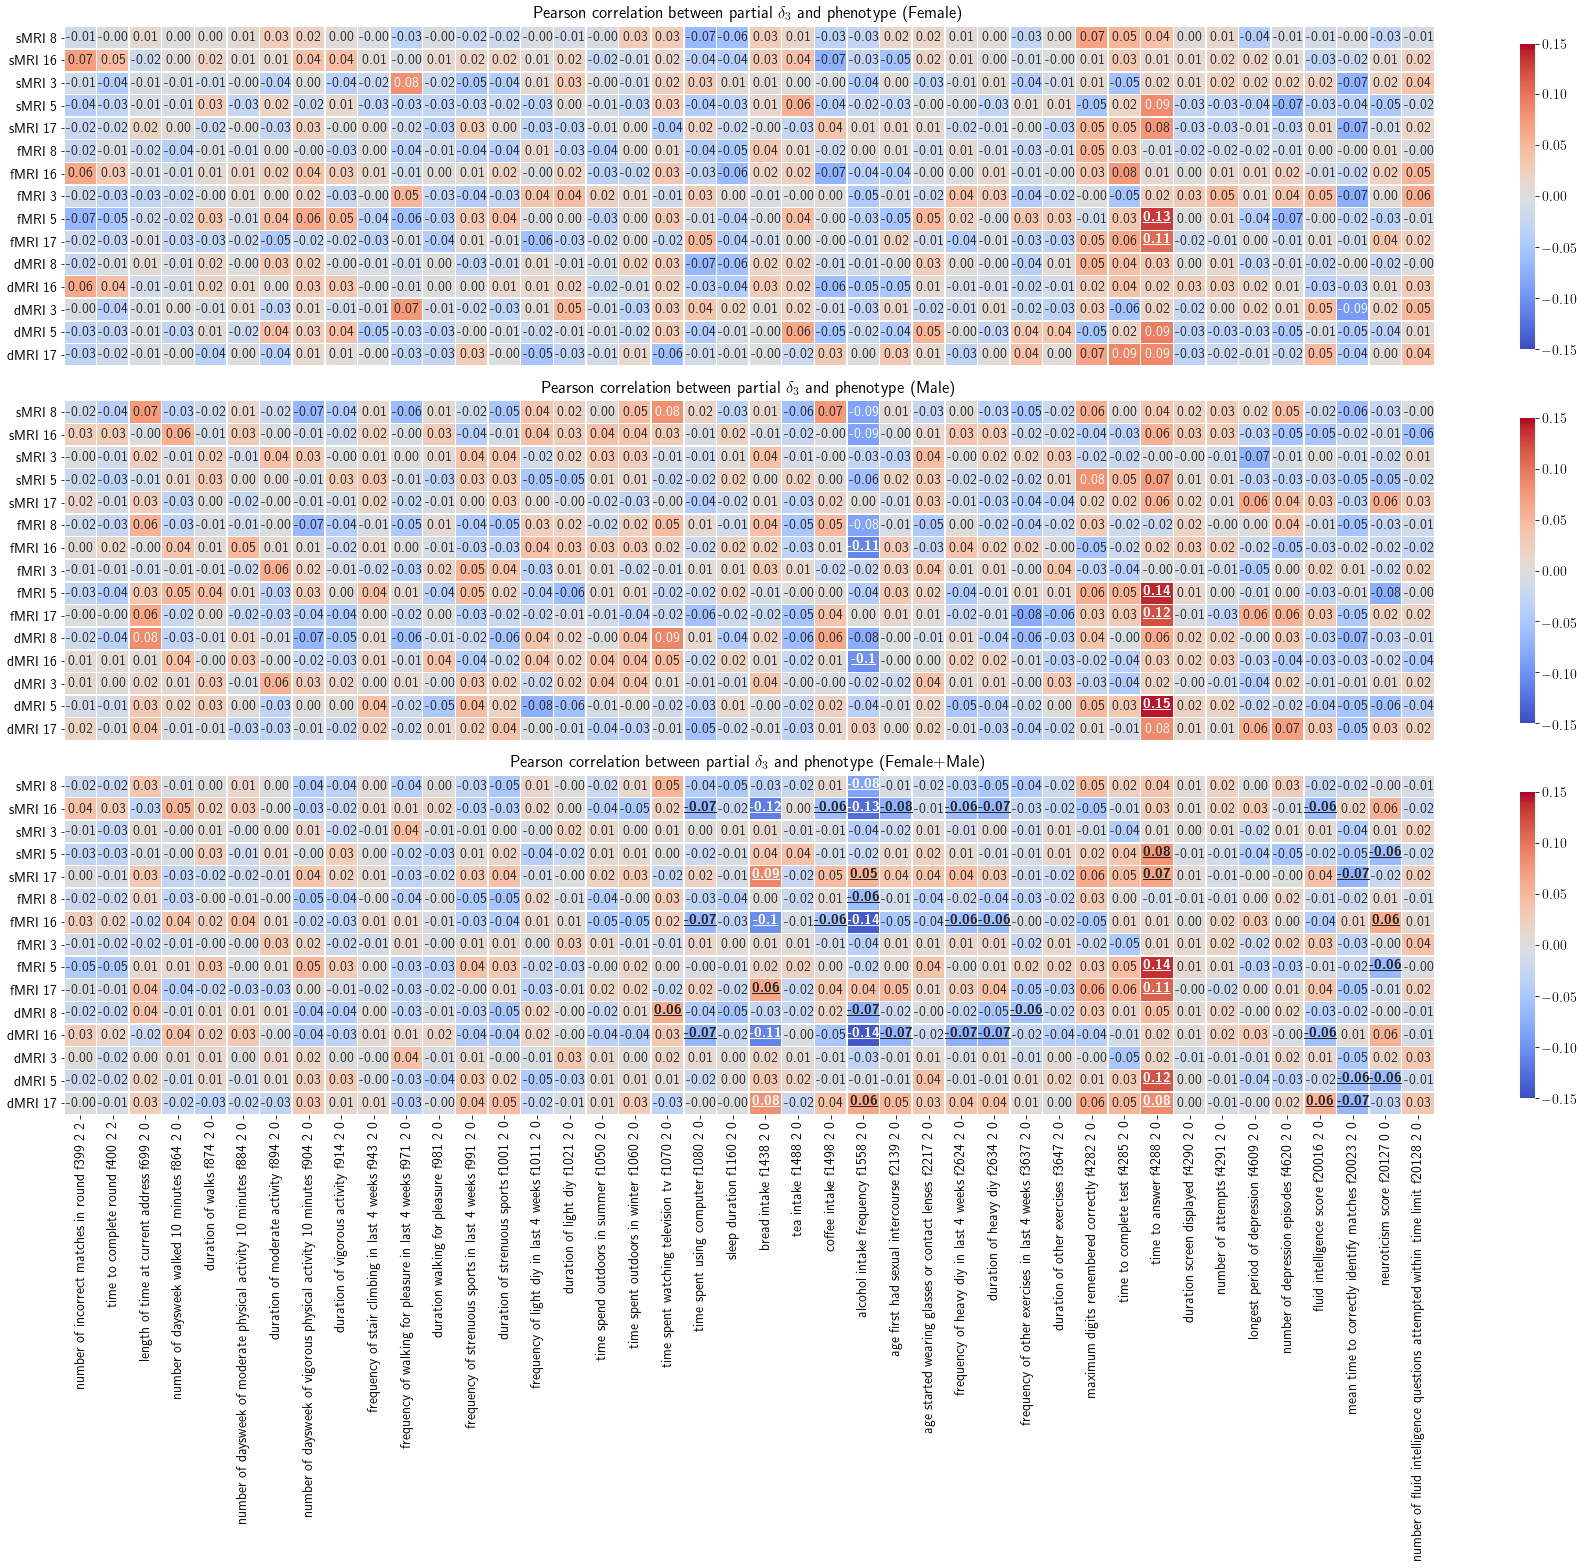

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25,22))

xticks = np.arange(0.5, 42.5, 1)
xticklabels = []
for i in range(42):
    pn = ukb_42var[i][0]
    xticklabels.append(pn.replace('_', ' '))

# Activating tex in all labels globally
plt.rc('text', usetex=True)
# Adjust font specs as desired (here: closest similarity to seaborn standard)
plt.rc('font', **{'size': 14.0})

yticks = np.arange(0.5, 6.5, 1)
g1 = sns.heatmap(r2[1,:,:], mask=rej2[1,:,:], annot=True, linewidths=.5, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .9}, vmin=-0.15, vmax=0.15, xticklabels=False, yticklabels=xtick_label_sorted, ax=ax1)
g1.set_title("Pearson correlation between partial $\delta_{3}$ and phenotype (Female)")
g1.set_yticks(yticks)
g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
sns.heatmap(r2[1,:,:], mask=rej2[1,:,:]==False, 
            annot=np.array([r'\textbf{\underline{' + str(round(data,2)) + '}}'
                        for data in r2[1,:,:].ravel()]).reshape(
            np.shape(r2[1,:,:])),
            linewidths=.5, fmt='', cmap="coolwarm", cbar=False, cbar_kws={"shrink": .9}, vmin=-0.15, vmax=0.15, xticklabels=False, yticklabels=xtick_label_sorted, ax=ax1)

g2 = sns.heatmap(r2[0,:,:], mask=rej2[0,:,:], annot=True, linewidths=.5, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .9}, vmin=-0.15, vmax=0.15, xticklabels=False, yticklabels=xtick_label_sorted, ax=ax2)
g2.set_title("Pearson correlation between partial $\delta_{3}$ and phenotype (Male)")
g2.set_yticks(yticks)
g2.set_yticklabels(g2.get_yticklabels(), rotation=0)
sns.heatmap(r2[0,:,:], mask=rej2[0,:,:]==False, 
            annot=np.array([r'\textbf{\underline{' + str(round(data,2)) + '}}'
                        for data in r2[0,:,:].ravel()]).reshape(
            np.shape(r2[0,:,:])),
            linewidths=.5, fmt='', cmap="coolwarm", cbar=False, cbar_kws={"shrink": .9}, vmin=-0.15, vmax=0.15, xticklabels=False, yticklabels=xtick_label_sorted, ax=ax2)

g3 = sns.heatmap(r2[2,:,:], mask=rej2[2,:,:], annot=True, linewidths=.5, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .9}, vmin=-0.15, vmax=0.15, xticklabels=xticklabels, yticklabels=xtick_label_sorted, ax=ax3)
g3.set_title("Pearson correlation between partial $\delta_{3}$ and phenotype (Female+Male)")
g3.set_xticks(xticks)
g3.set_yticks(yticks)
g3.set_yticklabels(g3.get_yticklabels(), rotation=0)
sns.heatmap(r2[2,:,:], mask=rej2[2,:,:]==False,
            annot=np.array([r'\textbf{\underline{' + str(round(data,2)) + '}}'
                        for data in r2[2,:,:].ravel()]).reshape(
            np.shape(r2[2,:,:])),
            linewidths=.5, fmt='', cmap="coolwarm", cbar=False, cbar_kws={"shrink": .9}, vmin=-0.15, vmax=0.15, xticklabels=xticklabels, yticklabels=xtick_label_sorted, ax=ax3)

plt.tight_layout()
plt.savefig("partial_delta3_42var_corr_underscore.pdf", dpi=200)